# keras embedding을 이용한 문서 분류

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [7]:
import pandas as pd

In [22]:
df = pd.read_csv("sms_spam.csv")

In [23]:
df.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [24]:
categories = list(df['type'].values)
emails = list(df['text'].values)

In [25]:
from keras.preprocessing.text import Tokenizer

max_words = 5000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(emails)

X = tokenizer.texts_to_sequences(emails)
# 일반적으로 0이면 unknown, 즉 전체단어의 수가 10000개 - num_words가 넘을 경우, index가 10000-1(for unknown)을 넘어가는 단어는 0으로 처리함
#onehot_train = tokenizer.texts_to_matrix(X_train, mode='binary')

print('num of tokens:', len(tokenizer.word_index))

num of tokens: 8953


In [26]:
bow = tokenizer.texts_to_matrix(emails, mode='binary')
bow.shape

(5559, 5000)

In [27]:
from keras import preprocessing

maxlen = 500

X = preprocessing.sequence.pad_sequences(X, maxlen=maxlen, truncating='pre')
print(X[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [16]:
label_dict = {'ham':0, 'spam':1}
y = [label_dict[c] for c in categories]
print(y[:10])

[0, 0, 0, 1, 1, 0, 0, 0, 1, 0]


In [33]:
from sklearn.model_selection import train_test_split #sklearn에서 제공하는 split 함수를 사용
import numpy as np
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# sklearn의 train_test_split 함수는 먼저 data set을 shuffle하고 주어진 비율에 따라 train set과 test set을 나눠 줌
# 위에서는 reviews를 X_train과 X_test로 8:2의 비율로 나누고, categories를 y_train과 y_test로 나눔
# 이 때 X와 y의 순서는 동일하게 유지해서 각 입력값과 label이 정확하게 match되도록 함
# random_state는 shuffle에서의 seed 값으로, 지정한 경우 항상 동일한 결과로 shuffle이 됨

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 4447
Test set count: 1112
Test samples: [0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0]


In [37]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train,  epochs=30, batch_size=256, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 16001     
Total params: 176,001
Trainable params: 176,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
14/14 [==============================] - 0s 21ms/step - loss: 0.4193 - acc: 0.8080 - val_loss: 0.3105 - val_acc: 0.8955
Epoch 2/30
14/14 [==============================] - 0s 13ms/step - loss: 0.3588 - acc: 0.8575 - val_loss: 0.2667 - val_acc: 0.8955
Epoch 3/30
14/14 [==============================] - 0s 14ms/step - loss: 0.2968 - acc: 0.8589 - val_loss: 0.2254 - v

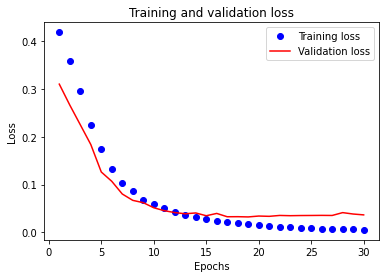

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [39]:
score = model.evaluate(X_test, y_test)
print(score)

35/35 [==============================] - 0s 2ms/step - loss: 0.0261 - acc: 0.9937
[0.026079989969730377, 0.9937050342559814]


In [40]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
14/14 [==============================] - 1s 64ms/step - loss: 0.5005 - acc: 0.8181 - val_loss: 0.2793 - val_acc: 0.8955
Epoch 2/30
14/14 [==============================] - 0s 32ms/step - loss: 0.2890 - acc: 0.8636 - val_loss: 0.1898 - val_acc: 0.9000
Epoch 3/30
14/14 [==============================] - 0s 32ms/step - loss: 0.1965 - acc: 0.9221 - val_loss: 0.1499 - val_acc: 0.9360
Epoch 4/30
14/14 [==============================] - 0s 33ms/step - loss: 0.1497 - acc: 0.9584 - val_loss: 0.1360 - val_acc: 0.9854
Epoch 5/30
14/14 [==============================] - 0s 32ms/step - loss: 0.1142 - acc: 0.9767 - val_loss: 0.0878 - val_acc: 0.9876
Epoch 6/30
14/14 [==============================] - 0s 32ms/step - loss: 0.0957 - acc: 0.9820 - val_loss: 0.0717 - val_acc: 0.9820
Epoch 7/30
14/14 [==============================] - 0s 32ms/step - loss: 0.0750 - acc: 0.9876 - val_loss: 0.0620 - val_acc: 0.9933
Epoch 8/30
14/14 [==============================] - 0s 33ms/step - loss: 0.0594 - a

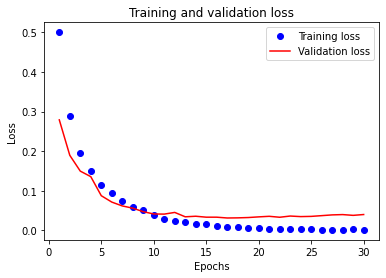

In [42]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

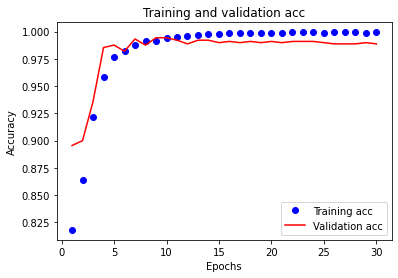

In [43]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [44]:
score = model.evaluate(X_test, y_test)
print(score)

35/35 [==============================] - 0s 10ms/step - loss: 0.0376 - acc: 0.9928
[0.037586670368909836, 0.9928057789802551]


#### train set의 크기가 학습을 시키기에 충분하였다.